## This is a simple baseline implementation for multinput pytorch pipeline to combine both Patient Features and Image Features . I am just trying it out . It might be wrong as well , so please take it with a pinch of salt . Inspiration is below , However , this version focuses on creating a simple pipeline with few features and simple network . 

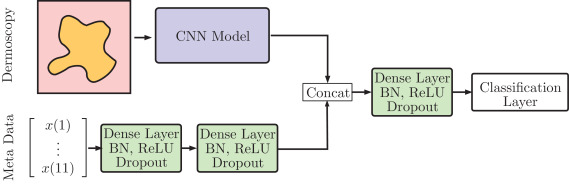

## As you can mainly see , the maximum portion of code is copied from this two kernels. I removed the notes from Tarun's Kernel because , he has already made a great kernel , it will be redundant if i paste here .

https://www.kaggle.com/tarunpaparaju/siim-isic-melanoma-eda-pytorch-baseline


https://www.kaggle.com/tunguz/melanoma-classification-eda-and-modeling


In [ ]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py

In [ ]:
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [ ]:
!export XLA_USE_BF16=1
!pip install -q colored
!pip install -q efficientnet_pytorch

In [ ]:
import os
import gc
import cv2
import time
import numpy as np
import pandas as pd

from colored import fg, attr
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import torch
import torch.nn as nn
from torch.optim import Adam
from torch import FloatTensor, LongTensor, DoubleTensor

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, sampler
from torch.utils.data.distributed import DistributedSampler

from efficientnet_pytorch import EfficientNet
from albumentations import Normalize, VerticalFlip, HorizontalFlip, Compose

In [ ]:
W = 512
H = 512
FRAC = 0.25
SPLIT = 0.8

EPOCHS = 2
LR = 1e-3, 1e-3
BATCH_SIZE = 32
VAL_BATCH_SIZE = 128

MODEL = 'efficientnet-b3'
TEST_IMG_PATH = '../input/siim-isic-melanoma-classification/jpeg/test/'
TRAIN_IMG_PATH = '../input/siim-isic-melanoma-classification/jpeg/train/'

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
print(os.listdir('../input/siim-isic-melanoma-classification'))

In [ ]:
test_df = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')
train_df = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')

In [ ]:
test_df.head(10)

In [ ]:
train_df.head(10)

In [ ]:
def display_images(num):
    sq_num = np.sqrt(num)
    assert sq_num == int(sq_num)

    sq_num = int(sq_num)
    image_ids = os.listdir(TEST_IMG_PATH)
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(20, 20))

    for i in range(sq_num):
        for j in range(sq_num):
            idx = i*sq_num + j
            ax[i, j].axis('off')
            img = cv2.cvtColor(cv2.imread(TEST_IMG_PATH + image_ids[idx]), cv2.COLOR_BGR2RGB)
            ax[i, j].imshow(img); ax[i, j].set_title('Test Image {}'.format(idx), fontsize=12)

    plt.show()

In [ ]:
display_images(36)

In [ ]:
## Create Feature 

train_df['sex_feat'] = (train_df['sex'].values == 'male')*1
test_df['sex_feat'] = (test_df['sex'].values == 'male')*1

train_df['age_approx_feat'] = train_df['age_approx'].fillna(train_df['age_approx'].mean())
test_df['age_approx_feat'] = test_df['age_approx'].fillna(test_df['age_approx'].mean())

In [ ]:
train_df['age_approx_feat'] = train_df['age_approx_feat'] /train_df['age_approx_feat'].values.max()

In [ ]:
test_df['age_approx_feat'] = test_df['age_approx_feat'] /test_df['age_approx_feat'].values.max()

In [ ]:
train_df['anatom_site_general_challenge_feat'] = train_df['anatom_site_general_challenge'].fillna('unknown')
test_df['anatom_site_general_challenge_feat'] = test_df['anatom_site_general_challenge'].fillna('unknown')

In [ ]:
train_df['diagnosis'] = train_df['diagnosis'].fillna('na')


In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
for df in [train_df,test_df]:
    df['anatom_site_general_challenge_feat_c'] = lb_make.fit_transform(df['anatom_site_general_challenge_feat'])

train_df['diag_aux'] = lb_make.fit_transform(train_df['diagnosis'])



In [ ]:
feat_columns=['sex_feat','age_approx_feat','anatom_site_general_challenge_feat_c']

In [ ]:
train_feat = train_df[feat_columns].copy()
test_feat = test_df[feat_columns].copy()

In [ ]:
def ToTensor(data):
    return [FloatTensor(point) for point in data]

class SIIMFeatDataset(Dataset):
    def __init__(self, df, aug, targ, ids, path):
        self.df, self.targ, self.aug = df, targ, aug

        self.mu = [0.485, 0.456, 0.406]
        self.sigma = [0.229, 0.224, 0.225]
        self.img_ids, self.img_path = ids, path
        self.norm = Normalize(mean=self.mu, std=self.sigma, p=1)
        self.vflip, self.hflip = VerticalFlip(p=0.5), HorizontalFlip(p=0.5)
        
        if self.aug: self.transformation = self.norm
        else: self.transformation = Compose([self.norm, self.vflip, self.hflip])

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, i):
        feat_columns=['sex_feat','age_approx_feat','anatom_site_general_challenge_feat_c'] 
        target = [self.df.target[i]] if self.targ else 0
        feat = self.df[feat_columns].values[i]
        image = cv2.imread(self.img_path + self.img_ids[i])
        image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (H, W))
        return ToTensor([self.transformation(image=image)['image'], target,feat])

In [ ]:
### Checking the dataset function
train_ids = train_df.image_name.apply(lambda x: x + '.jpg')

train_set = SIIMFeatDataset(train_df, True, True, train_ids, TRAIN_IMG_PATH)
out = train_set[0]
out

In [ ]:
def GlobalAveragePooling(x):
    return x.mean(axis=-1).mean(axis=-1)

class CancerNet(nn.Module):
    def __init__(self, features):
        super(CancerNet, self).__init__()
        self.avgpool = GlobalAveragePooling
        self.dense_output = nn.Linear(features, 1)
        self.efn = EfficientNet.from_pretrained(MODEL)
        
    def forward(self, x):
        x = x.view(-1, 3, H, W)
        x = self.efn.extract_features(x)
        return self.dense_output(self.avgpool(x))

In [ ]:
class CancerNet2(nn.Module):
    def __init__(self, features,num_patient_feat):
        super(CancerNet2, self).__init__()
        self.avgpool = GlobalAveragePooling
        self.dense_output = nn.Linear(features, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.num_patient_feat = num_patient_feat 
        self.l0=nn.Linear(self.num_patient_feat,64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.3)
        self.conc_feat =128
        self.final_output = nn.Linear(128,1)
        self.efn = EfficientNet.from_pretrained(MODEL)
        
    def forward(self, x,train_patient_feat):
        x = x.view(-1, 3, H, W)
        x = self.efn.extract_features(x)

        x = self.avgpool(x)
       
        x = self.dense_output(x)
        x=  self.dropout(x)
        x_l0 = self.bn2(F.relu(self.l0(train_patient_feat)))
        x_l0 = self.dropout(x_l0)

        x = torch.cat((x,x_l0),1)
        
        
        x = self.final_output(x)
        return x

In [ ]:
## Check Net
import torch.nn.functional as F
device = xm.xla_device()
train_feat_dummy =torch.Tensor(np.random.randn(32,3)).to(device)
img_dummy = torch.Tensor(np.random.randn(32,3,512,512)).to(device)
net=CancerNet2(1536,3).to(device)
out = net(img_dummy,train_feat_dummy)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

def bce(y_true, y_pred):
    return nn.BCEWithLogitsLoss()(y_pred, y_true)


def roc_auc(y_true, y_pred):
    y_true = y_true.squeeze().cpu().detach().numpy()
    y_pred = nn.Sigmoid()(y_pred.squeeze()).cpu().detach().numpy()
    return roc_auc_score(y_true,y_pred)

In [ ]:
def print_metric(data, batch, epoch, start, end, metric, typ):
    t = typ, metric, "%s", data, "%s"
    if typ == "Train": pre = "BATCH %s" + str(batch-1) + "%s  "
    if typ == "Val": pre = "\nEPOCH %s" + str(epoch+1) + "%s  "
    time = np.round(end - start, 1); time = "Time: %s{}%s s".format(time)
    fs = [(fg(211), attr('reset')), (fg(212), attr('reset')), (fg(213), attr('reset'))]
    xm.master_print(pre % fs[0] + "{} {}: {}{}{}".format(*t) % fs[1] + "  " + time % fs[2])

In [ ]:
class ImbalancedSampler(sampler.Sampler):

    def __len__(self):
        return self.num_samples
    
    def _get_label(self, dataset, idx):
        return dataset.df["target"][idx]

    def __iter__(self):
        return (self.indices[i] for i in self._get_probs())
    
    def _get_weight(self, idx, count_dict):
        return 1.0/count_dict[self._get_label(self.dataset, idx)]
    
    def _get_probs(self):
        return torch.multinomial(self.weights, self.num_samples, replacement=True)

    def __init__(self, dataset, indices=None, num_samples=None):
        self.indices = list(range(len(dataset))) if indices is None else indices
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        count = {}
        self.dataset = dataset
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in count: count[label] += 1
            if label not in count: count[label] = 1

        self.weights = DoubleTensor([self._get_weight(idx, count) for idx in self.indices])

In [ ]:
cut = int(FRAC*len(train_df))
train_df = shuffle(train_df).reset_index(drop=True).loc[:cut]

split = int(SPLIT*len(train_df))
train_df, val_df = train_df.loc[:split], train_df.loc[split:]
train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

In [ ]:
val_ids = val_df.image_name.apply(lambda x: x + '.jpg')
train_ids = train_df.image_name.apply(lambda x: x + '.jpg')

val_set = SIIMFeatDataset(val_df, False, True, val_ids, TRAIN_IMG_PATH)
train_set = SIIMFeatDataset(train_df, True, True, train_ids, TRAIN_IMG_PATH)

train_sampler = ImbalancedSampler(train_set)
val_loader = DataLoader(val_set, VAL_BATCH_SIZE, shuffle=False)
train_loader = DataLoader(train_set, BATCH_SIZE, sampler=train_sampler)

device = xm.xla_device()
network = CancerNet2(features=1536,num_patient_feat=3).to(device)
optimizer = Adam([{'params': network.efn.parameters(), 'lr': LR[0]},
                  {'params': network.dense_output.parameters(), 'lr': LR[1]}])

#### Note : Something wrong with the metrics . May be someone can correct me .

In [ ]:
start = time.time()
xm.master_print("STARTING TRAINING ...\n")

for epoch in range(EPOCHS):
    fonts = (fg(48), attr('reset'))
    xm.master_print(("EPOCH %s" + str(epoch+1) + "%s") % fonts)
    
    batch = 1
    network.train()
    for train_batch in train_loader:
        train_img, train_targ ,train_feat= train_batch
        train_targ = train_targ.view(-1, 1)
        train_img, train_targ,train_feat = train_img.to(device), train_targ.to(device),train_feat.to(device)
            
        train_preds = network.forward(train_img,train_feat)
        train_auc = roc_auc(train_targ, train_preds)
        train_loss = bce(train_targ, train_preds)
            
        optimizer.zero_grad()
        train_loss.backward()
        xm.optimizer_step(optimizer, barrier=True)
            
        end = time.time()
        batch = batch + 1
        auc = np.round(train_auc.item(), 3)
        if batch %1 ==0:
            print_metric(auc, batch, 0, start, end, metric="roc-auc", typ="Train")
            
    network.eval()
    val_loss, val_auc, val_points = 0, 0, 0
        
    with torch.no_grad():
        for val_batch in tqdm(val_loader):
            val_img, val_targ,val_feat = val_batch
            val_targ = val_targ.view(-1, 1)
            val_img, val_targ,val_feat = val_img.to(device), val_targ.to(device),val_feat.to(device)

            val_points += len(val_targ)
            val_preds = network.forward(val_img,val_feat)
            val_auc += roc_auc(val_targ, val_preds).item()*len(val_preds)
            val_loss += bce(val_targ, val_preds).item()*len(val_preds)
        
    end = time.time()
    val_auc /= val_points
    val_loss /= val_points
    auc = np.round(val_auc, 3)
    print_metric(auc, 0, epoch, start, end, metric="roc-auc", typ="Val")
    
    xm.master_print("")

xm.master_print("\nENDING TRAINING ...")

## Visualize sample test predictions

* Now since the model is trained, we will visualize predictions made on unseen test images.

In [ ]:
def display_preds(num,test_df):
    sq_num = np.sqrt(num)
    assert sq_num == int(sq_num)

    sq_num = int(sq_num)
    image_ids = os.listdir(TEST_IMG_PATH)
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(20, 20))
    norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1)
    feat_columns=['sex_feat','age_approx_feat','anatom_site_general_challenge_feat_c'] 
    
    for i in range(sq_num):
        for j in range(sq_num):
            idx = i*sq_num + j
            ax[i, j].axis('off')
            pred_dict = {0: '"No-Melanoma"', 1: '"Melanoma"'}
            print(image_ids[idx])
            img = cv2.resize(cv2.cvtColor(cv2.imread(TEST_IMG_PATH + image_ids[idx]), cv2.COLOR_BGR2RGB), (H, W))
            pred = nn.Sigmoid()(network.forward(FloatTensor(norm(image=img)['image'].reshape(1, 3, H, W)).to(device),FloatTensor(test_df.loc[test_df.image_name==image_ids[idx].split('.')[0]][feat_columns].values).to(device)))
            ax[i, j].imshow(img); ax[i, j].set_title('Prediction: {}'.format(pred_dict[round(pred.item())]), fontsize=12)

    plt.show()

In [ ]:
display_preds(16,test_df)

## Run inference on the test data

* Next I will run inference on the test data and store the test predictions in a list.
* These predictions are logits and will be converted to probabilities later using <code>sigmoid</code>.

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

test_ids = test_df.image_name.apply(lambda x: x + '.jpg')
test_set = SIIMFeatDataset(test_df, False, False, test_ids, TEST_IMG_PATH)
test_loader = tqdm(DataLoader(test_set, VAL_BATCH_SIZE, shuffle=False))

network.eval()
test_preds = []
with torch.no_grad():
    for test_batch in test_loader:       
        test_img,label, test_feat = test_batch
        test_img = test_img.to(device)
        test_feat = test_feat.to(device)
        test_preds.extend(network.forward(test_img,test_feat).squeeze().detach().cpu().numpy())

In [ ]:
path = '../input/siim-isic-melanoma-classification/'
sample_submission = pd.read_csv(path + 'sample_submission.csv')

In [ ]:
sample_submission.target = sigmoid(np.array(test_preds))

In [ ]:
sample_submission.head()

In [ ]:
sample_submission.to_csv('submission.csv', index=False)